In [16]:
from sklearn.datasets import make_blobs
from numpy.random import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt
from pyod.models.iforest import IForest
from pyod.models.dif import DIF
from pyod.models.loda import LODA
from pyod.utils.utility import standardizer
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

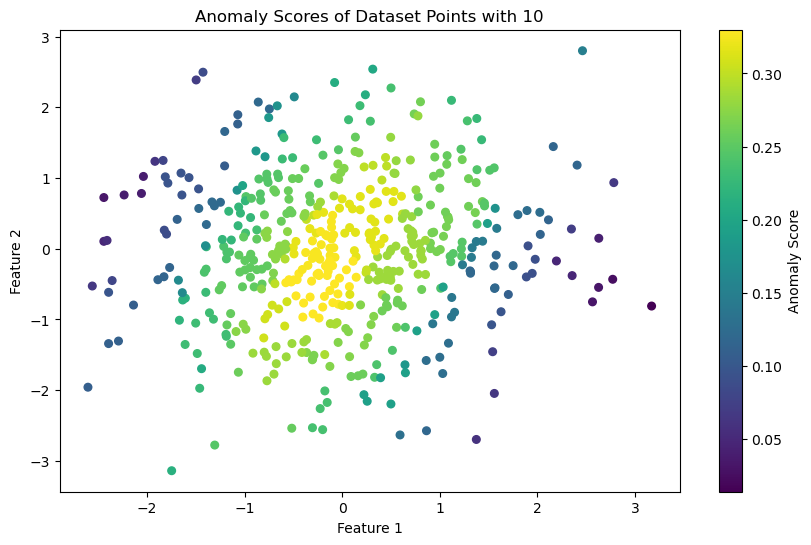

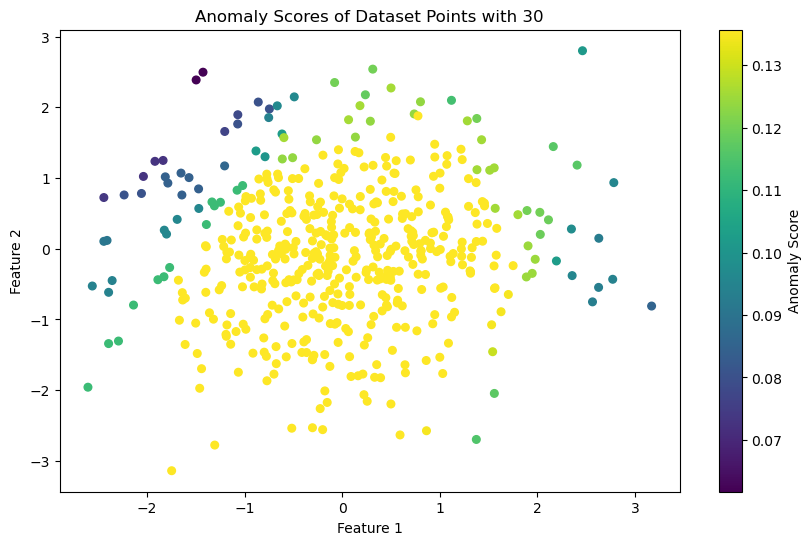

In [59]:
#ex1
dataset,_=make_blobs(n_samples=500,n_features=2,cluster_std=1.0,centers=[[0,0]])
vectors=multivariate_normal(mean=(0,0),cov=np.eye(2),size=5)


def create_bins(num_bins):
    histograms = []
    bin_edges_list = []
    for vector in vectors:
        projected_data = dataset @ vector
        data_range = (projected_data.min() - 1, projected_data.max() + 1)
        histogram, bin_edges = np.histogram(projected_data, bins=num_bins, range=data_range, density=True)
        
        histograms.append(histogram)
        bin_edges_list.append(bin_edges)

    return histograms, bin_edges_list
    
def test_anomaly(dataset,histograms,bin_edges_list):
    anomaly_scores=[]
    for sample in dataset:
        score=0
        for idx,vector in enumerate(vectors):
            projection=sample@vector
            bin_edges=bin_edges_list[idx]
    
            bin_index=np.searchsorted(bin_edges,projection)-1
            bin_index = min(max(bin_index, 0), len(histogram) - 1)
            score+=histograms[idx][bin_index]
        anomaly_scores.append(score/len(vectors))
    
    anomaly_scores = np.array(anomaly_scores)
    return anomaly_scores

def ex1(dataset,num_bins=10):
    histograms, bin_edges_list=create_bins(num_bins)
    anomaly_scores=test_anomaly(dataset,histograms, bin_edges_list)
    plt.figure(figsize=(10, 6))
    plt.scatter(dataset[:, 0], dataset[:, 1], c=anomaly_scores, cmap='viridis', s=30)
    plt.colorbar(label='Anomaly Score')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'Anomaly Scores of Dataset Points with {num_bins} bins')
    plt.show()
for bins in [10,30]:
    ex1(dataset,bins)
    

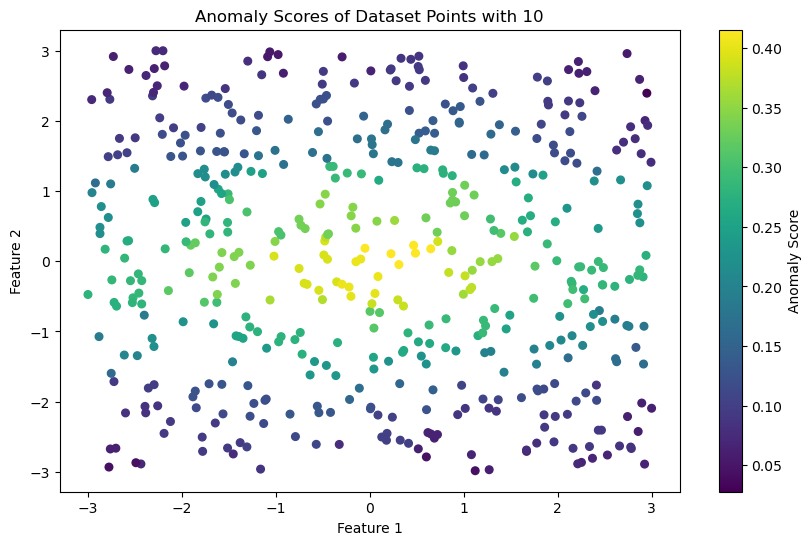

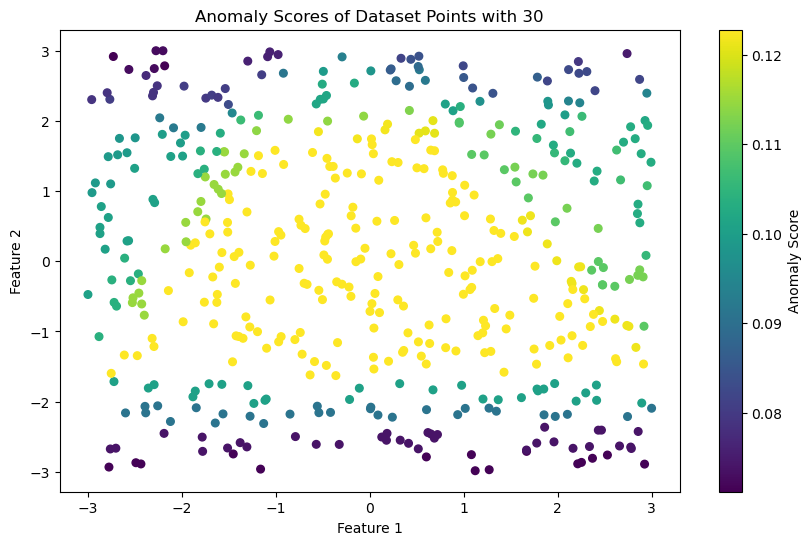

In [58]:
test_set=np.random.uniform(low=-3,high=3,size=(500,2))
for bins in [10,30]:
    ex1(test_set,bins)

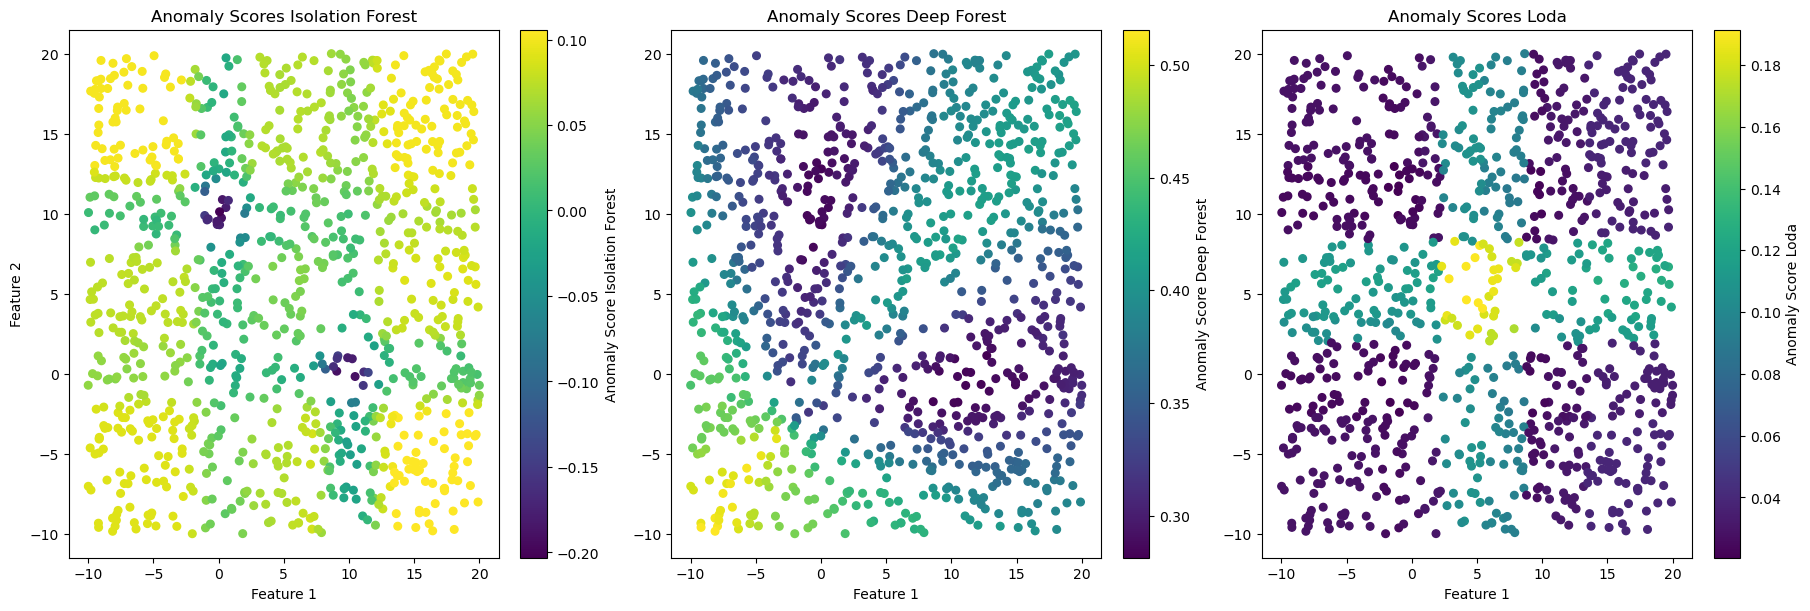

In [14]:
#ex2
train_set,_=make_blobs(n_samples=500,n_features=2,cluster_std=1.0,centers=[[10,0],[0,10]])
test_set=np.random.uniform(low=-10,high=20,size=(1000,2))

forest=IForest(contamination=0.02)
forest.fit(train_set)
results=forest.decision_function(test_set)

d_forest=DIF(contamination=0.02)
d_forest.fit(train_set)
results_d=d_forest.decision_function(test_set)

loda=LODA(contamination=0.02)
loda.fit(train_set)
results_l=loda.decision_function(test_set)


fig, axs = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# First subplot for Isolation Forest
scatter1 = axs[0].scatter(test_set[:, 0], test_set[:, 1], c=results, cmap='viridis', s=30)
axs[0].set_title('Anomaly Scores Isolation Forest')
axs[0].set_xlabel('Feature 1')
axs[0].set_ylabel('Feature 2')
fig.colorbar(scatter1, ax=axs[0], label='Anomaly Score Isolation Forest')

# Second subplot for Deep Forest
scatter2 = axs[1].scatter(test_set[:, 0], test_set[:, 1], c=results_d, cmap='viridis', s=30)
axs[1].set_title('Anomaly Scores Deep Forest')
axs[1].set_xlabel('Feature 1')
fig.colorbar(scatter2, ax=axs[1], label='Anomaly Score Deep Forest')

# Third subplot for Loda
scatter3 = axs[2].scatter(test_set[:, 0], test_set[:, 1], c=results_l, cmap='viridis', s=30)
axs[2].set_title('Anomaly Scores Loda')
axs[2].set_xlabel('Feature 1')
fig.colorbar(scatter3, ax=axs[2], label='Anomaly Score Loda')

plt.show()


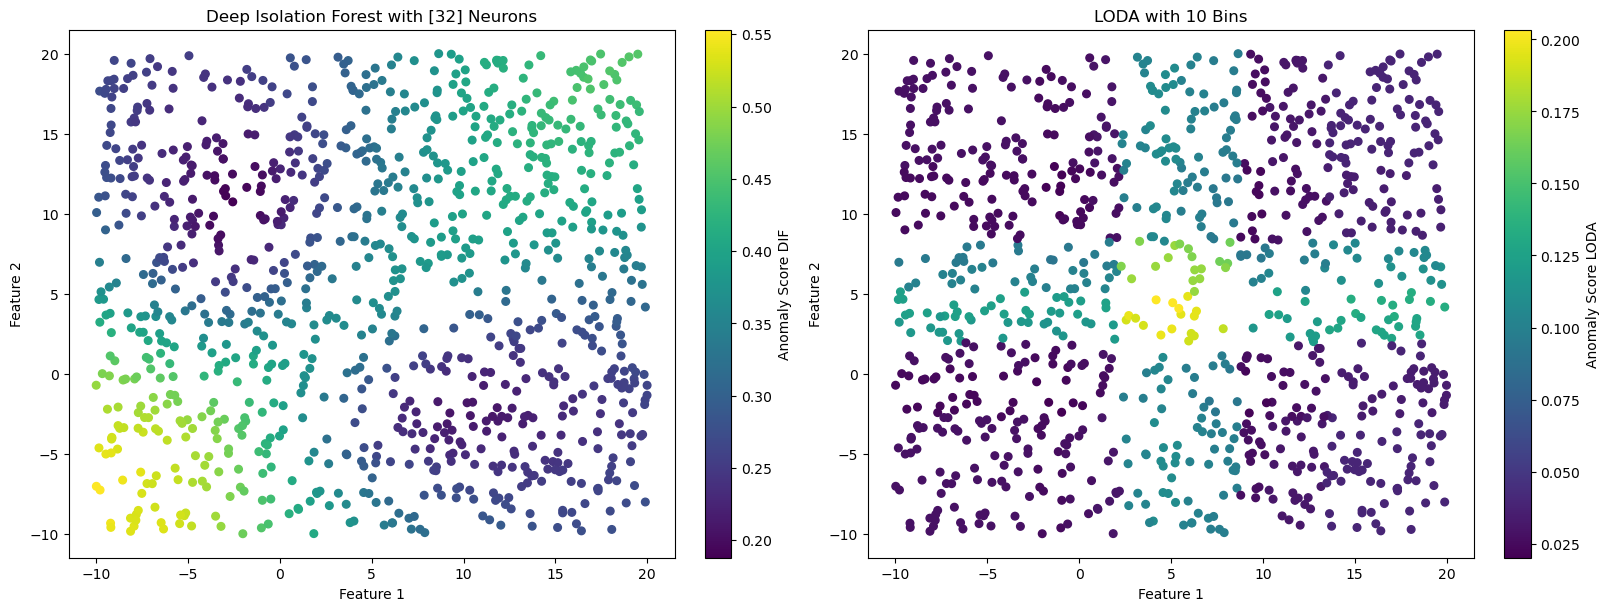

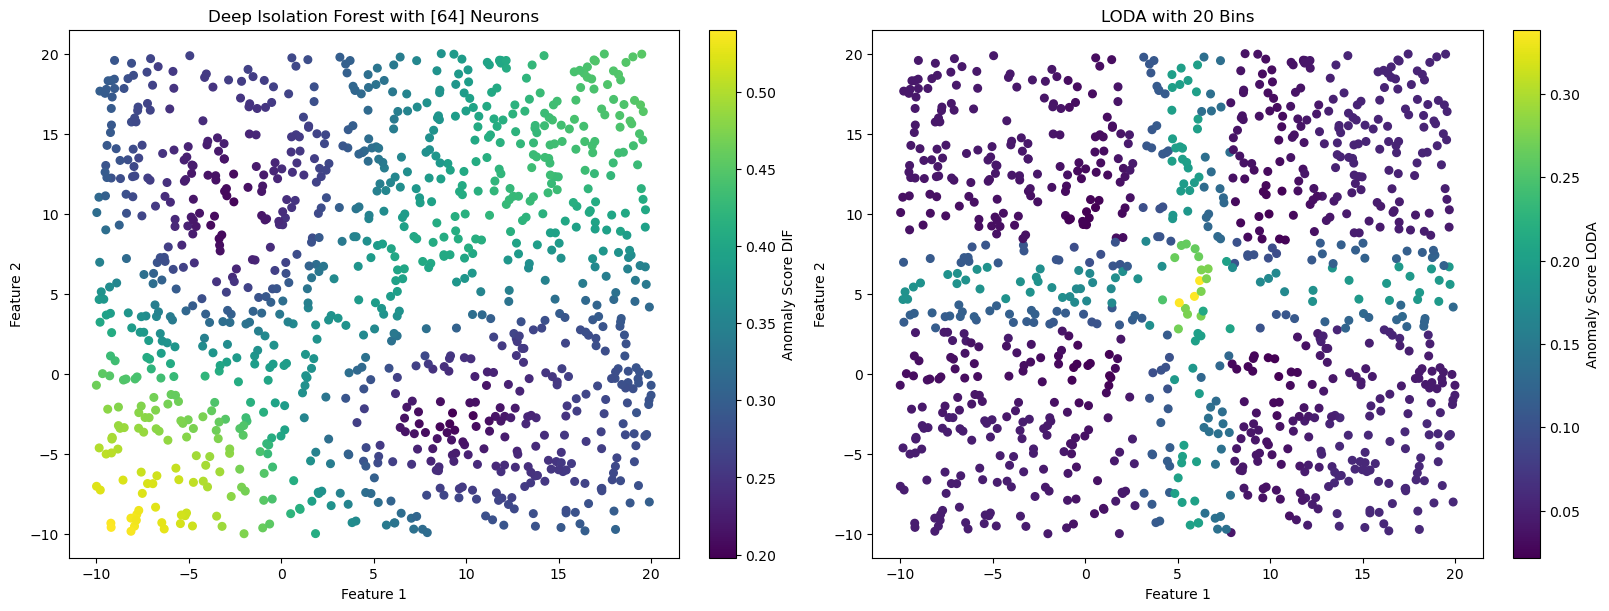

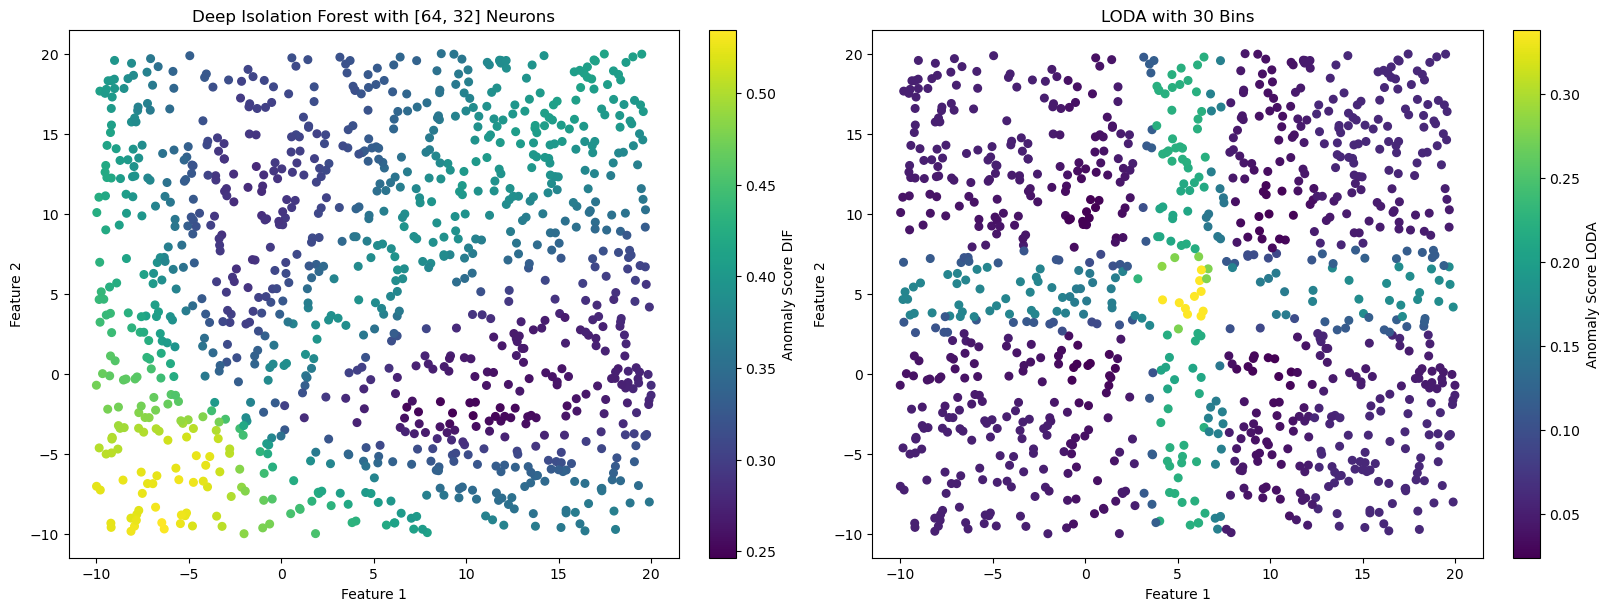

In [16]:
#ex2.5

neurons=[[32],[64],[64,32]]
bins=[10,20,30]
for n,b in zip(neurons,bins):
    dif=DIF(contamination=0.02,hidden_neurons=n)
    loda=LODA(contamination=0.02,n_bins=b)
    dif.fit(train_set)
    loda.fit(train_set)

    results_d=dif.decision_function(test_set)
    results_l=loda.decision_function(test_set)

    fig, axs = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

    scatter1 = axs[0].scatter(test_set[:, 0], test_set[:, 1], c=results_d, cmap='viridis', s=30)
    axs[0].set_title(f'Deep Isolation Forest with {n} Neurons')
    axs[0].set_xlabel('Feature 1')
    axs[0].set_ylabel('Feature 2')
    fig.colorbar(scatter1, ax=axs[0], label='Anomaly Score DIF')

    # Subplot for LODA
    scatter2 = axs[1].scatter(test_set[:, 0], test_set[:, 1], c=results_l, cmap='viridis', s=30)
    axs[1].set_title(f'LODA with {b} Bins')
    axs[1].set_xlabel('Feature 1')
    axs[1].set_ylabel('Feature 2')
    fig.colorbar(scatter2, ax=axs[1], label='Anomaly Score LODA')

    plt.show()

LODA detects more anomalies as the number of bins increases because we will have bins with a small number of points. So LODA will consider as anomalies or at least will give a higher anomaly score to the points that fall there.

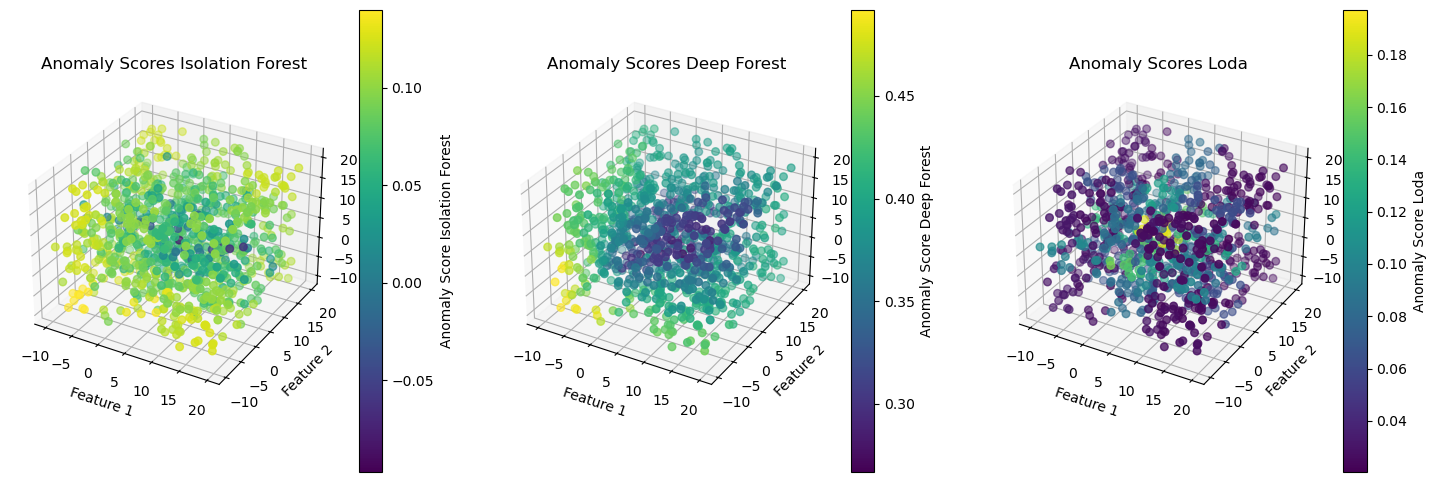

In [19]:
#2.6
train_set,_=make_blobs(n_samples=500,n_features=3,cluster_std=1.0,centers=[[0,10,0],[10,0,10]])
test_set=np.random.uniform(low=-10,high=20,size=(1000,3))

forest=IForest(contamination=0.02)
forest.fit(train_set)
results=forest.decision_function(test_set)

d_forest=DIF(contamination=0.02)
d_forest.fit(train_set)
results_d=d_forest.decision_function(test_set)

loda=LODA(contamination=0.02)
loda.fit(train_set)
results_l=loda.decision_function(test_set)

fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

# First subplot for Isolation Forest
scatter1 = ax1.scatter(test_set[:, 0], test_set[:, 1], test_set[:, 2], c=results, cmap='viridis', s=30)
ax1.set_title('Anomaly Scores Isolation Forest')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.set_zlabel('Feature 3')
fig.colorbar(scatter1, ax=ax1, label='Anomaly Score Isolation Forest')

# Second subplot for Deep Forest
scatter2 = ax2.scatter(test_set[:, 0], test_set[:, 1], test_set[:, 2], c=results_d, cmap='viridis', s=30)
ax2.set_title('Anomaly Scores Deep Forest')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.set_zlabel('Feature 3')
fig.colorbar(scatter2, ax=ax2, label='Anomaly Score Deep Forest')

# Third subplot for Loda
scatter3 = ax3.scatter(test_set[:, 0], test_set[:, 1], test_set[:, 2], c=results_l, cmap='viridis', s=30)
ax3.set_title('Anomaly Scores Loda')
ax3.set_xlabel('Feature 1')
ax3.set_ylabel('Feature 2')
ax3.set_zlabel('Feature 3')
fig.colorbar(scatter3, ax=ax3, label='Anomaly Score Loda')

plt.show()

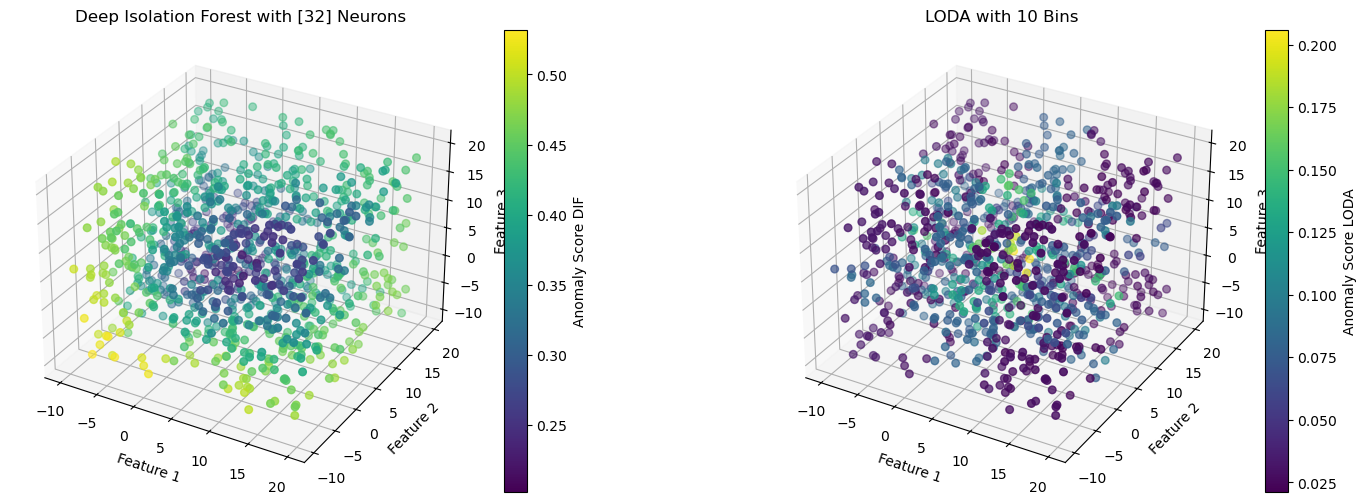

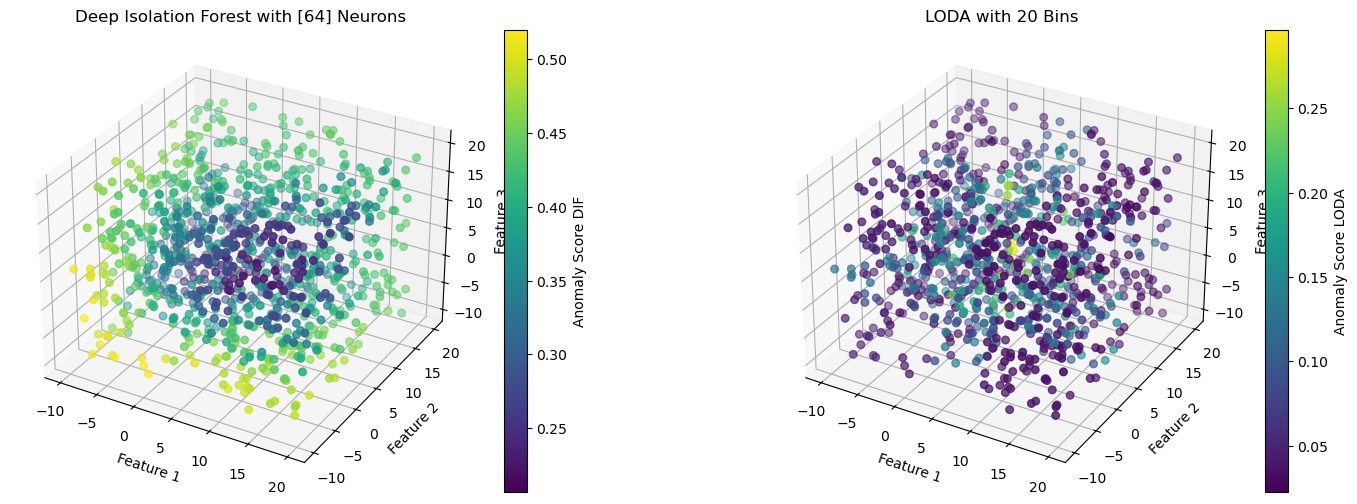

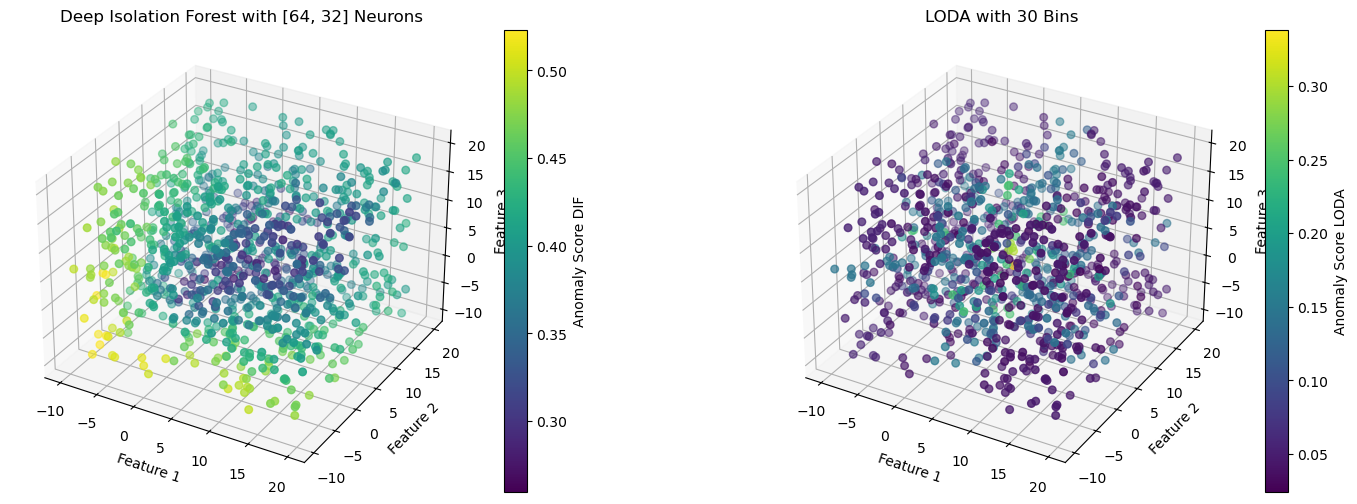

In [21]:
#2.6.5
neurons=[[32],[64],[64,32]]
bins=[10,20,30]
for n,b in zip(neurons,bins):
    dif=DIF(contamination=0.02,hidden_neurons=n)
    loda=LODA(contamination=0.02,n_bins=b)
    dif.fit(train_set)
    loda.fit(train_set)

    results_d=dif.decision_function(test_set)
    results_l=loda.decision_function(test_set)

    fig = plt.figure(figsize=(18, 6))
    
    # Subplot for Deep Isolation Forest
    ax1 = fig.add_subplot(121, projection='3d')
    scatter1 = ax1.scatter(test_set[:, 0], test_set[:, 1], test_set[:, 2], c=results_d, cmap='viridis', s=30)
    ax1.set_title(f'Deep Isolation Forest with {n} Neurons')
    ax1.set_xlabel('Feature 1')
    ax1.set_ylabel('Feature 2')
    ax1.set_zlabel('Feature 3')
    fig.colorbar(scatter1, ax=ax1, label='Anomaly Score DIF')

    # Subplot for LODA
    ax2 = fig.add_subplot(122, projection='3d')
    scatter2 = ax2.scatter(test_set[:, 0], test_set[:, 1], test_set[:, 2], c=results_l, cmap='viridis', s=30)
    ax2.set_title(f'LODA with {b} Bins')
    ax2.set_xlabel('Feature 1')
    ax2.set_ylabel('Feature 2')
    ax2.set_zlabel('Feature 3')
    fig.colorbar(scatter2, ax=ax2, label='Anomaly Score LODA')

    plt.show()

    plt.show()


In [19]:
#ex3
data=loadmat("shuttle.mat")
ba={}
roc={}
ba["isolation forest"]=[]
ba["deep isolation forest"]=[]
ba["LODA"]=[]

roc["isolation forest"]=[]
roc["deep isolation forest"]=[]
roc["LODA"]=[]
def ex3():
    X_train, X_test, y_train, y_test = train_test_split(data["X"], data["y"], test_size=0.4,random_state=np.random.randint(1000))
    X_train, X_test = standardizer(X_train, X_test)
    print(X_train.shape,X_test.shape)

    c_rate=sum([1 for y in y_train if y==1])/len(y_train)

    forest=IForest(contamination=c_rate)
    forest.fit(X_train)
    results=forest.decision_function(X_test)
    pred_f=forest.predict(X_test)
    
    d_forest=DIF(contamination=c_rate)
    d_forest.fit(X_train)
    results_d=d_forest.decision_function(X_test)
    pred_d=d_forest.predict(X_test)
    
    loda=LODA(contamination=c_rate)
    loda.fit(X_train)
    results_l=loda.decision_function(X_test)
    pred_l=loda.predict(X_test)

    auc=roc_auc_score(y_test,results)
    roc["isolation forest"].append(auc)
    auc=roc_auc_score(y_test,results_d)
    roc["deep isolation forest"].append(auc)
    auc=roc_auc_score(y_test,results_l)
    roc["LODA"].append(auc)

    acc=compute_balanced_accuracy(pred_f,y_test)
    ba["isolation forest"].append(acc)
    acc=compute_balanced_accuracy(pred_d,y_test)
    ba["deep isolation forest"].append(acc)
    acc=compute_balanced_accuracy(pred_l,y_test)
    ba["LODA"].append(acc)


def compute_balanced_accuracy(pred, labels):
    tp, fn, fp, tn=confusion_matrix(labels, pred).ravel()
    sensitivity=tp/(tp+fn)
    specifity=tn/(fp+tn)
    balanced_accuracy=(specifity + sensitivity)/2
    return balanced_accuracy

for _ in tqdm(range(10)):
    ex3()



    

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

(29458, 9) (19639, 9)


 10%|████████▏                                                                         | 1/10 [01:56<17:27, 116.39s/it]

(29458, 9) (19639, 9)


 20%|████████████████▍                                                                 | 2/10 [04:03<16:21, 122.66s/it]

(29458, 9) (19639, 9)


 30%|████████████████████████▌                                                         | 3/10 [06:03<14:10, 121.44s/it]

(29458, 9) (19639, 9)


 40%|████████████████████████████████▊                                                 | 4/10 [08:00<11:58, 119.80s/it]

(29458, 9) (19639, 9)


 50%|█████████████████████████████████████████                                         | 5/10 [10:06<10:08, 121.79s/it]

(29458, 9) (19639, 9)


 60%|█████████████████████████████████████████████████▏                                | 6/10 [12:02<08:00, 120.07s/it]

(29458, 9) (19639, 9)


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [13:59<05:57, 119.06s/it]

(29458, 9) (19639, 9)


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [15:56<03:56, 118.40s/it]

(29458, 9) (19639, 9)


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [17:54<01:58, 118.16s/it]

(29458, 9) (19639, 9)


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [19:52<00:00, 119.22s/it]


In [20]:
for model in ba.keys():
    print(f"Model: {model}")
    print(f"Mean Balanced Accuracy: {np.mean(ba[model]):.4f}")
    print(f"Mean ROC AUC: {np.mean(roc[model]):.4f}")

Model: isolation forest
Mean Balanced Accuracy: 0.9757
Mean ROC AUC: 0.9974
Model: deep isolation forest
Mean Balanced Accuracy: 0.5084
Mean ROC AUC: 0.9641
Model: LODA
Mean Balanced Accuracy: 0.6103
Mean ROC AUC: 0.4935
